<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/DSSP_Illustrations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discrete Fourier Transform

The following code uses SciPy to compute the discrete fourier transform as introduced in the lecture notes on page 72 (as of 2020). You may play around with the values in the time domain as well as the signal length and plot the results.

In [ ]:
import ipywidgets as widgets
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
%matplotlib inline
#-------------------------------------------------------------------------------

fG = []
FG = []
def update_parameters(f):
  global fG, FG
  try:
    fG = [int(s) for s in f.split()]
    #Important Stuff
    ############################################################################
    FG = [np.round(v,2) for v in fft(fG)] #computes DFT (rounding to 2 decimal places) as FFT (fast fourier transform)
    ############################################################################
    print("F = ", list(FG))
  except:
    pass #catches bad input
widgets.interact(update_parameters, f="10 5 3 9 3 10");

def illustrate3():
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
  ax1.set_xlabel('$k$', fontsize=14)
  ax1.set_ylabel('$f[k]]$', fontsize=14)
  ax1.stem(range(len(fG)), np.abs(fG))

  ax2.set_xlabel('$n$', fontsize=14)
  ax2.set_ylabel('$f[n]$', fontsize=14)
  ax2.stem(range(len(FG)), np.abs(FG))

interactive(children=(Text(value='10 5 3 9 3 10', description='f'), Output()), _dom_classes=('widget-interact'…

Try out the discrete fourier transform with different values (and different signal lengths). The graphs are plotted below for illustration.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


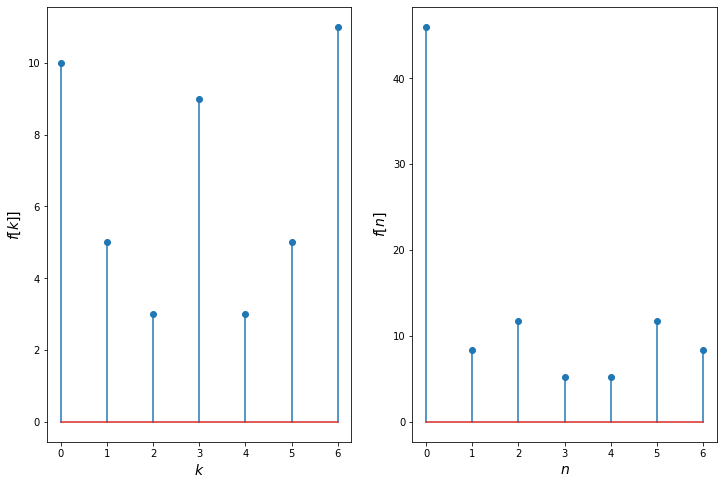

In [ ]:
illustrate3()

# Fast Fourier Transform

We wish to compute the discrete fourier transform (DFT) of a signal $f[k]$ which we assume has length $N$. We know the DFT to be given by
$$F[n] = F(\alpha^n) = \sum\limits_{k=0}^{N-1} f[k] \alpha^{-kn}$$
Computing the DFT for $n \in \{0,\ldots,N-1\}$ thus runs in $\mathcal{O}(N^2)$.

The Cooley-Tukey FFT (page 77 as of 2020) improves the runtime of the DFT to $\mathcal{O}(\log(N) \cdot N)$. We shall quickly motivate its construction. <br>
Assuming $N = N_1 \cdot N_2$ we can decompose $F(z)$ into $F(z) = \sum\limits_{k_1=0}^{N_1-1} F_{k_1} (z^{N_1}) z^{-k_1}$ and $F_{k_1} (z) = \sum\limits_{k_2=0}^{N_2-1} f[N_1 k_2 + k_1] z^{-k_2}$. We can use the same decomposition for the DFT with $n = N_2 n_1 + n_2$ to get
$$F[N_2 n_1 + n_2] = \sum\limits_{k_1=0}^{N_1-1} \left[ F_{k_1} ((\alpha^{N_1})^{n_2}) \alpha^{-k_1 n_2} \right] (\alpha^N_2)^{-k_1 n_1}$$

Thus instead of calculating 1 DFT of size $N = N_1 \cdot N_2$ we can calculate $N_1$ DFT's of size $N_2$ cutting the runtime from $N^2 = N_1^2 \cdot N_2^2$ to $N_1 \cdot N_2^2$. We can perform this decomposition repeatedly until we only have to compute very small DFT's. Of course there are additional operations that need to be done to combine the results, but the main savings leading to a runtime of $\mathcal{O}(\log(N)\cdot N)$ should be clear.

We may implement the aforementioned decomposition of the DFT in a 5 step procedure as describe in the lecture notes on page 78 (as of 2020). The steps are:



1.   Write the data row after row into a matrix with $N_2$ rows and $N_1$ columns.
2.   Replace every column by its DFT with $\alpha_1 = \alpha^N_1$.
3.   Multiply every element of the matrix with  $\alpha^{- k_1 n_2}$ where $n_2$ indicates the row and $k_1$ the column (0 indexed).
4.   Replace every row by its DFT with $\alpha_2 = \alpha^{N_2}$.
5.   Read data column after column.

In [ ]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#-------------------------------------------------------------------------------

#Important Stuff
################################################################################
def dft(f, alpha):
  F = [0]*len(f)
  for n in range(len(F)):
    for k in range(len(f)):
      F[n] += f[k] * alpha**(- k * n)
  return F
################################################################################

def update(N_1, f):
  try:
    f = np.array([int(s) for s in f.split()])
    f.reshape(f.size,1)
    alpha = np.exp(2j*np.pi/f.size)
    if f.size % N_1 != 0:
      raise #exception thrown since reshaping is impossible
    N_2 = f.size//N_1
    #convert to table 
    f_table = np.resize(f, (N_2, N_1))

    #Important Stuff
    ############################################################################
    f_table_columnDFT = np.zeros(f_table.shape, dtype = 'complex_')
    for c in range(N_1):
      f_table_columnDFT[:,c] = dft(f_table[:,c], alpha**(N_1))
      
    f_table_columnDFT_adjusted = np.zeros(f_table_columnDFT.shape, dtype = 'complex_')
    for k_1 in range(N_1):
      for n_2 in range(N_2):
        f_table_columnDFT_adjusted[n_2, k_1] = f_table_columnDFT[n_2, k_1] * alpha**(- k_1 * n_2)

    f_tableDFT = np.zeros(f_table_columnDFT_adjusted.shape, dtype = 'complex_')
    for r in range(N_2):
      f_tableDFT[r,:] = dft(f_table_columnDFT_adjusted[r,:], alpha**(N_2))
    ############################################################################

    f_DFT = np.reshape(f_tableDFT, (f.size,1))
    #f_table_columnDFT = [fft(col)]

    print(np.round(f, 2))
    print("\nStep 1")
    print(np.round(f_table, 2))
    print("\nStep 2")
    print(np.round(f_table_columnDFT, 2))
    print("\nStep 3")
    print(np.round(f_table_columnDFT_adjusted, 2))
    print("\nStep 4")
    print(np.round(f_tableDFT, 2))
    print("\nStep 5")
    print(np.round(f_DFT, 2))
    print("\nF = ", np.reshape(np.round(f_DFT, 2),(1,f_DFT.size)).tolist()[0])
  except:
    pass #catches bad input as well as invalid dimensions
widgets.interact(update, N_1 = widgets.IntSlider(min=1, max=5, value=2), f="10 5 3 9 3 10");

interactive(children=(IntSlider(value=2, description='N_1', max=5, min=1), Text(value='10 5 3 9 3 10', descrip…

[(40-0j), (5.5+4.33j), (8.5+4.33j), (-8-0j), (8.5-4.33j), (5.5-4.33j)]

Above you can see the 5 steps of the FFT decomposition perform on an adjustable signal. You may also change the layout of the decomposition by changing the parameter $N_1$.

# Gaussian Probability Density Function

The gaussian distribution (as introduced in the lecture notes on page 125 as of 2020) will be of great importance to this course (and life in general). Its pdf is plotted below.
$$f_X(x) = \frac{1}{\sqrt{2\pi}\sigma_X} \exp \left(-\frac{(x-m_X)^2}{2\sigma_X^2} \right) \propto \exp \left ( - \frac{x^2}{2\sigma_X^2} + x \frac{m_X}{\sigma_X^2}\right)$$


In [ ]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#-------------------------------------------------------------------------------

#read in parameters
m_xG = 0
sigma_xG = 1
def update_parameters(m_x, sigma_x):
  global m_xG, sigma_xG
  m_xG, sigma_xG = m_x, sigma_x
widgets.interact(update_parameters, m_x = widgets.FloatSlider(min=-10, max=10, value=0), sigma_x = widgets.FloatSlider(min=0.1, max=10, value=1));

#Important Stuff
################################################################################
#function to be plotted
gaussian_pdf = lambda x, m_x, sigma_x: 1/(np.sqrt(2*np.pi)*sigma_x) * np.exp(-(x-m_x)**2 / (2*sigma_x**2))
################################################################################
#range to display
x_values = np.arange(-10,10,0.1)

def plot():
  y_values = gaussian_pdf(x_values, m_xG, sigma_xG)

  fig, ax = plt.subplots(figsize=(12, 8))
  ax.grid()
  ax.set_xlabel('$x$', fontsize=14)
  ax.set_ylabel('$f(x \mid \mu_x, \sigma_x)$', fontsize=14)
  ax.axis(xmin=x_values[0], xmax=x_values[-1])
  ax.plot(x_values, y_values, alpha=0.5, marker='o', markersize=8);

interactive(children=(FloatSlider(value=0.0, description='m_x', max=10.0, min=-10.0), FloatSlider(value=1.0, d…

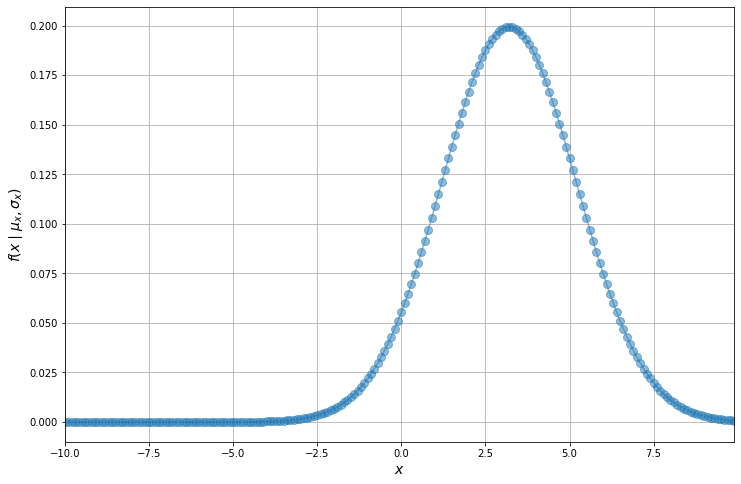

In [ ]:
plot()

# Maximum Likelihood Estimation (MLE) and Maximum A Posteriori Estimation (MAP)

We wish to perform a noisy measurement (lecture notes page 125 as of 2020). Both the unknown $X$ and the noise $W$ are modelled as gaussian random variables. We wish to estimate $\hat{X}$ from $Y$.
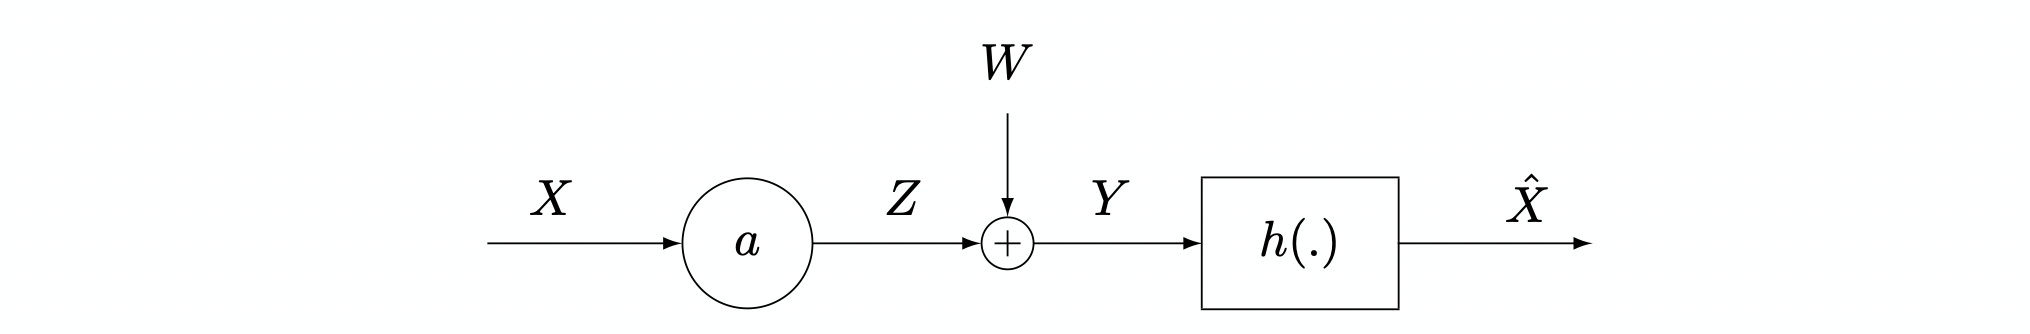

In [ ]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
#-------------------------------------------------------------------------------

#read in parameters
m_xG = 0
sigma_xG = 3
aG = 1
sigma_wG = 3
def update_parameters(m_x, sigma_x, sigma_w, a):
  global m_xG, sigma_xG, sigma_wG, aG
  m_xG, sigma_xG, sigma_wG, aG = m_x, sigma_x, sigma_w, a
widgets.interact(update_parameters, m_x = widgets.FloatSlider(min=-10, max=10, value=0), sigma_x = widgets.FloatSlider(min=0.1, max=10, value=3), sigma_w = widgets.FloatSlider(min=0.1, max=10, value=3), a = widgets.FloatSlider(min=0.1, max=10, value=1));

#Important Stuff
################################################################################
#X and W are both gaussian R.V.
gaussian_pdf = lambda x, m_x, sigma_x: 1/(np.sqrt(2*np.pi)*sigma_x) * np.exp(-(x-m_x)**2 / (2*sigma_x**2))
################################################################################

#range to display
x_values = np.arange(-10,10,0.5)
w_values = np.arange(-10,10,0.5)
y_values = np.arange(-10,10,0.5)

def illustrate():
  #Important Stuff
  ##############################################################################
  fx_values = gaussian_pdf(x_values, m_xG, sigma_xG) #f(x)
  fw_values = gaussian_pdf(w_values, 0, sigma_wG) #f(w)
  X, Y = np.meshgrid(x_values, y_values)
  fxy_values = gaussian_pdf(X, m_xG, sigma_xG) * gaussian_pdf(Y-aG*X, 0, sigma_wG) #f(y,x)
  ##############################################################################

  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 3, 1)
  ax1.grid()
  ax1.set_xlabel('$x$', fontsize=14)
  ax1.set_ylabel('$f(x \mid \mu_x, \sigma_x)$', fontsize=14)
  ax1.axis(xmin=x_values[0], xmax=x_values[-1])
  ax1.plot(x_values, fx_values, alpha=0.5, marker='o', markersize=8);

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.grid()
  ax2.set_xlabel('$w$', fontsize=14)
  ax2.set_ylabel('$f(w \mid \sigma_W)$', fontsize=14)
  ax2.axis(xmin=w_values[0], xmax=w_values[-1])
  ax2.plot(w_values, fw_values, alpha=0.5, marker='o', markersize=8);

  ax3 = fig.add_subplot(1, 3, 3, projection='3d')
  ax3.plot_surface(X, Y, fxy_values, cmap='terrain', alpha=0.6)
  ax3.plot_wireframe(X, Y, fxy_values, color='black', alpha=0.5, linewidths=1)
  ax3.set(xlabel='$x$', ylabel='$y$')
  ax3.set_zlabel('$f(y, x)$', labelpad=10)

interactive(children=(FloatSlider(value=0.0, description='m_x', max=10.0, min=-10.0), FloatSlider(value=3.0, d…

The code cell above allows you to set parameters for the distributions of $X$ and $W$. This will affect how MLE, MAP and Bayesian MMSE estimation will estimate $X$ given $Y$. Below the pdf of $X$ and $W$ as well as the joint pdf of $X$ and $Y$ are plotted for illustration.

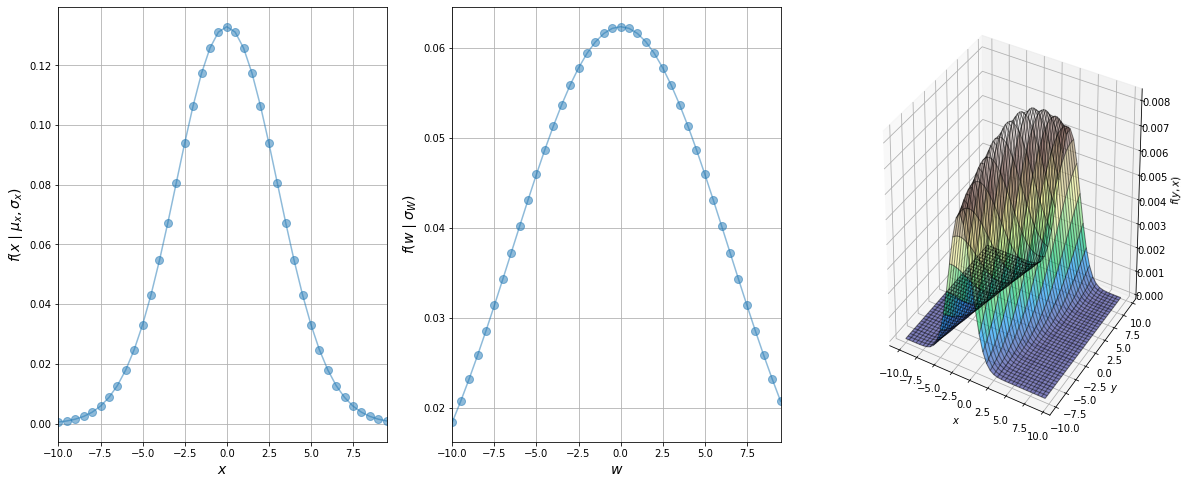

In [ ]:
illustrate()

In [ ]:
#read in parameter
yG = 0
def update_y(y):
  global yG
  yG = y
widgets.interact(update_y, y = widgets.FloatSlider(min=-10, max=10, value=0));

def illustrate2():
  #Important Stuff
  ##############################################################################
  fx_y_values = gaussian_pdf(yG-aG*x_values, 0, sigma_wG) #f(y|x)
  x_hat1 = yG/aG #MSE

  fxy_values = gaussian_pdf(x_values, m_xG, sigma_xG) * gaussian_pdf(yG-aG*x_values, 0, sigma_wG) #f(y,x)
  x_hat2 = (m_xG/sigma_xG**2 + aG*yG/sigma_wG**2)/(1/sigma_xG**2 + aG**2/sigma_wG**2) #MAP

  x_hat3 = (sigma_wG**2 * m_xG + aG * sigma_xG**2 * yG)/(sigma_wG**2 + aG**2 * sigma_xG**2) #MAP
  ##############################################################################
  
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))

  ax1.grid()
  ax1.set_xlabel('$x$ with MLE $\hat{x} =$ ' + "{:.2f}".format(x_hat1), fontsize=14)
  ax1.set_ylabel('$f(y \mid x)$', fontsize=14)
  ax1.axis(xmin=x_values[0], xmax=x_values[-1])
  ax1.plot(x_values, fx_y_values, alpha=0.5, marker='o', markersize=8);

  ax2.grid()
  ax2.set_xlabel('$x$ with MAP $\hat{x} =$ ' + "{:.2f}".format(x_hat2) + " and Bayesian MMSE Estimate $\hat{x} =$ " + "{:.2f}".format(x_hat3), fontsize=14)
  ax2.set_ylabel('$f(x \mid y)$', fontsize=14)
  ax2.axis(xmin=x_values[0], xmax=x_values[-1])
  ax2.plot(x_values, fxy_values, alpha=0.5, marker='o', markersize=8);

interactive(children=(FloatSlider(value=0.0, description='y', max=10.0, min=-10.0), Output()), _dom_classes=('…

The code cell above allows you to set the observed value of $Y$ and compute MLE, MAP and Bayesian MMSE estimation. Below the conditional probabilities used for estimation are plotted. You can see that MLE and MAP estimation both pick out the maximum value of the pdf.

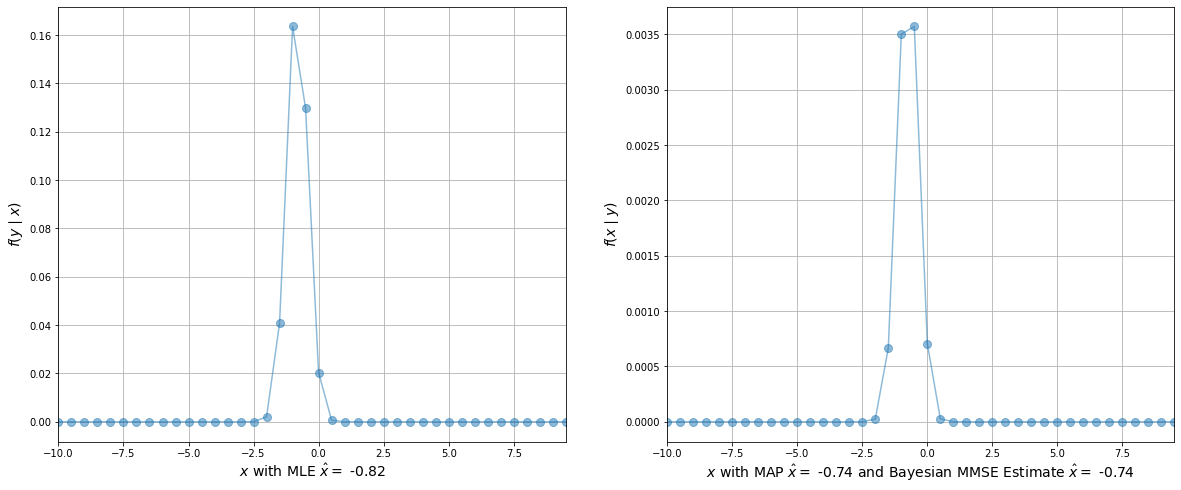

In [ ]:
illustrate2()

Notice that in this case MAP Estimation coincides with MMSE Estimation. Why is that? (Hint: The graph is symmetric around the peak)